In [411]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# NOT IMPOTANT Load Data

In [394]:
df = pd.read_csv('Final_Cleaned.csv', encoding='utf-8', sep=';')
df_clean = df.drop(columns=['latitude', 'longitude', 'sqm_price'])

In [395]:
new_column_names = {}

# Iterate through the existing column names and generate the new names
for column in df_clean.columns:
    new_name = column.lower().replace(" ", "_")  # Convert to lowercase and replace spaces
    new_column_names[column] = new_name

# Rename the columns using the generated names
df_clean.rename(columns=new_column_names, inplace=True)

In [396]:
df_final = df_clean.drop(columns=['city', 'municipal', 'residents',
                                 'distance_to_copenhagen', 'distance_to_aarhus', 'distance_to_odense', 'distance_to_aalborg'])

In [397]:
# Create dummy variables for the 'Category' column
dummy_1 = pd.get_dummies(df_final['property_type'], prefix='type',drop_first=True)
dummy_2 = pd.get_dummies(df_final['energy'], prefix = 'energy',drop_first=True)
dummy_3 = pd.get_dummies(df_final['closest_city'], prefix = 'close',drop_first=True)

# Concatenate the dummy variables with the original DataFrame
df_final = pd.concat([df_final, dummy_1,dummy_2,dummy_3], axis=1)
df_final = df_final.drop(columns=['property_type','energy','closest_city'])
#df_final

In [398]:
df_final.shape

(26527, 20)

Drop outliers

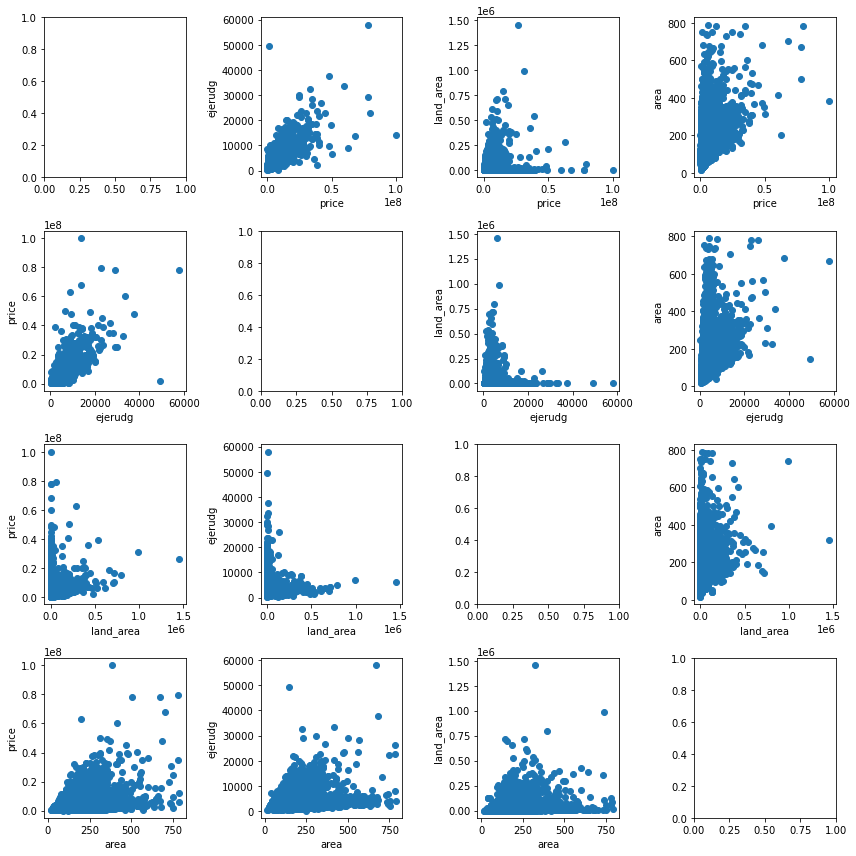

In [399]:
selected_columns = ['price', 'ejerudg', 'land_area', 'area']
# Create scatter plots
fig, axes = plt.subplots(nrows=len(selected_columns), ncols=len(selected_columns), figsize=(12, 12))

for i, col1 in enumerate(selected_columns):
    for j, col2 in enumerate(selected_columns):
        if col1 != col2:
            axes[i, j].scatter(df_final[col1], df_final[col2])
            axes[i, j].set_xlabel(col1)
            axes[i, j].set_ylabel(col2)

plt.tight_layout()
plt.show()

# Save the figure as a JPEG image
fig.savefig('outliers_scatterplot.png', format='png')

In [400]:
z_scores = np.abs((df_final[selected_columns] - df_final[selected_columns].mean()) / df_final[selected_columns].std())

# Define a Z-score threshold to identify outliers
z_threshold = 2.5

# Filter out rows with outliers
outlier_indices = np.where(z_scores > z_threshold)
filtered_indices = list(set(outlier_indices[0]))
df_filtered = df_final.drop(filtered_indices)

# Create scatter plots for filtered data

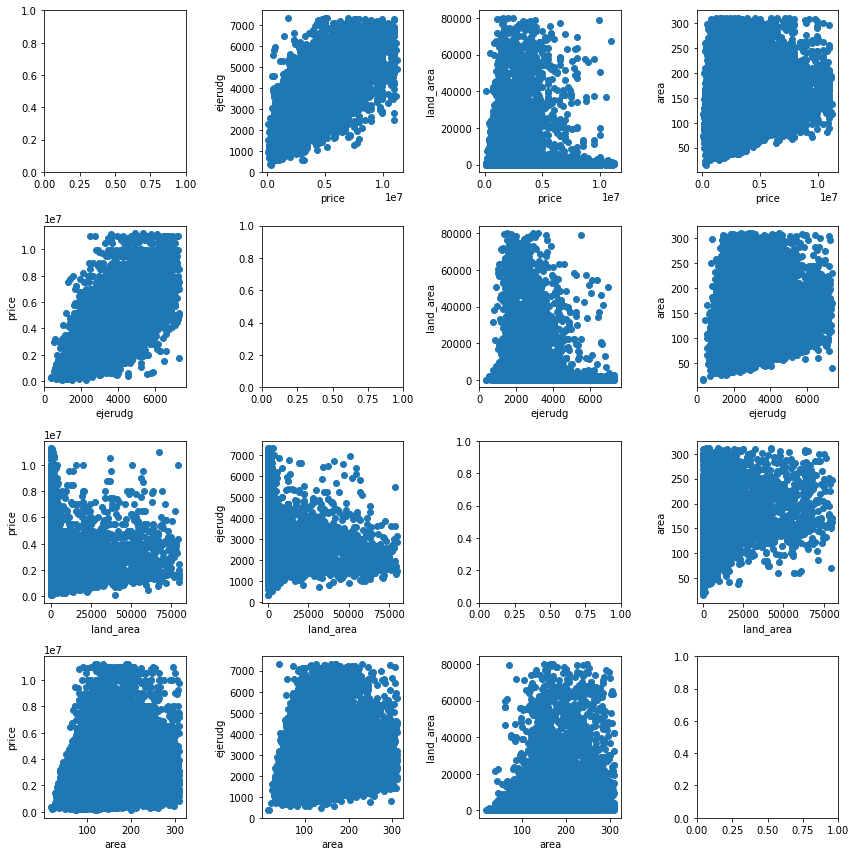

In [401]:
fig, axes = plt.subplots(nrows=len(selected_columns), ncols=len(selected_columns), figsize=(12, 12))

for i, col1 in enumerate(selected_columns):
    for j, col2 in enumerate(selected_columns):
        if col1 != col2:
            axes[i, j].scatter(df_filtered[col1], df_filtered[col2])
            axes[i, j].set_xlabel(col1)
            axes[i, j].set_ylabel(col2)

plt.tight_layout()
plt.show()

# Save the figure as a JPEG image
fig.savefig('no_outliers_scatterplot.png', format='png')

In [402]:
print(df_filtered.shape, df_final.shape)

(24863, 20) (26527, 20)


Drop duplicates

In [372]:
duplicates = df_filtered[df_filtered.duplicated()]
print(duplicates.shape)
df_final = df_filtered.drop_duplicates()
df_final.shape

(39, 20)


(25799, 20)

# START HERE

In [412]:
df_final = pd.read_csv('ml.csv', encoding='utf-8', sep=';')
df_final = df_final.iloc[:, 1:]
df_final.head()

price   area  land_area  rooms  ejerudg  days_active  distance_to_city  \
0  5195000.0   82.0      563.0    5.0   4894.0         87.0          5.126456   
1  2595000.0  192.0    20011.0    7.0   2077.0          6.0         72.075634   
2  3495000.0  116.0      794.0    4.0   3725.0         33.0         20.688457   
3  4500000.0  159.0      833.0    5.0   2862.0        229.0         42.015572   
4  1245000.0  157.0     1075.0    6.0   2101.0        105.0         51.888689   

   residents  municipal_tax_rate  grundskyldspromille  ...  type_Villa  \
0   644431.0               23.70                34.00  ...           1   
1    55340.0               26.30                24.36  ...           1   
2    50818.0               24.42                16.94  ...           1   
3    61718.0               25.26                21.04  ...           1   
4    51606.0               25.50                26.00  ...           1   

   energy_B  energy_C  energy_D  energy_E  energy_F  energy_G  close_Aarhus  \
0         0         0         1         0         0         0             0   
1         0         0         1         0         0         0             0   
2         0         0         1         0         0         0             0   
3         1         0         0         0         0         0             0   
4         0         0         1         0         0         0             0   

   close_Copenhagen  close_Odense  
0                 1             0  
1                 0             1  
2                 1             0  
3                 1             0  
4                 0             1  

[5 rows x 21 columns]

# Machine learning models

In [436]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import LassoCV, RidgeCV

In [437]:
y = df_final['price']
X = df_final.drop(columns=['price'])

In [438]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

## Linear Regression

In [439]:
def create_pipeline_lr(degree):
    return make_pipeline(PolynomialFeatures(degree=degree, include_bias=False),
                        StandardScaler(),
                        LinearRegression())

# Loop through polynomial degrees
for degree in [1,2]:
    pipe_lr = create_pipeline_lr(degree)
    
    pipe_lr.fit(X_dev, y_dev)
    y_test_pred = pipe_lr.predict(X_test)

    test_rmse = np.sqrt(mse(y_test, y_test_pred))
    r2 = r2_score(y_test, y_test_pred)
    
    print(f"Degree {degree} Polynomial - R squared: {r2:.4f}")
    print(f"Degree {degree} Polynomial - RMSE: {test_rmse:.2f}")

Degree 1 Polynomial - R squared: 0.7398
Degree 1 Polynomial - RMSE: 1357754.00
Degree 2 Polynomial - R squared: 0.8177
Degree 2 Polynomial - RMSE: 1136509.49


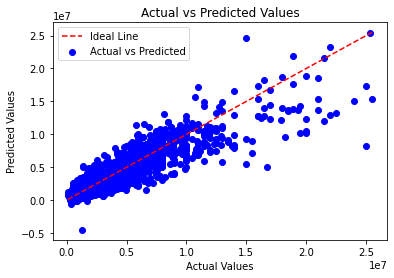

In [440]:
# Plot y_test vs y_pred
plt.scatter(y_test, y_test_pred, color='blue', label='Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', label='Ideal Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

Coefficients: [ 288691.01745103  209699.84082422   23490.80214475 1850862.52003425
  -63795.65506612 -249190.76725396  282394.10993108 -184826.70647163
 -224408.85846579   93936.89699507  209579.98522293  -22475.76020635
 -215992.6060179  -298331.27450671 -238610.8817583  -211224.85591417
 -187309.62509645  -41555.44495434   38403.30446817  -54668.71716756]


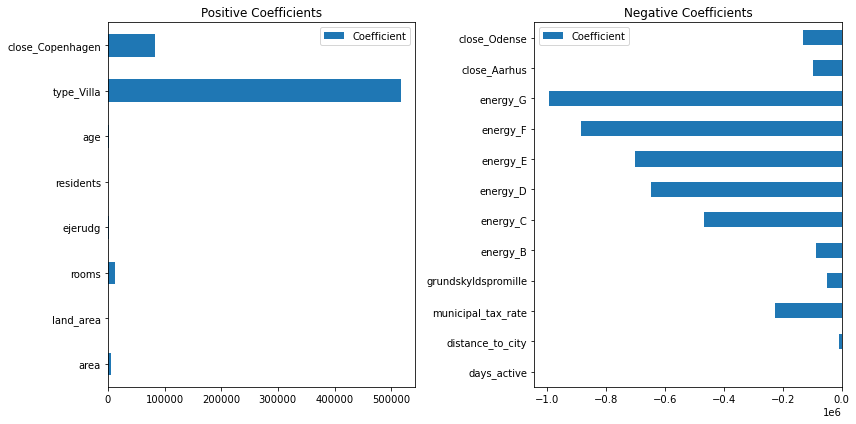

In [442]:
pipe_lr = create_pipeline_lr(1)
    
pipe_lr.fit(X_dev, y_dev)
y_test_pred = pipe_lr.predict(X_test)

coefficients = pipe_lr.get_params(deep=True)
coefficients = pipe_lr.named_steps['linearregression'].coef_
print("Coefficients:", coefficients)
scaling_factors = pipe_lr.named_steps['standardscaler'].scale_
rescaled_coefficients = coefficients / scaling_factors

# Create a DataFrame with rescaled coefficients and feature names
coef_df = pd.DataFrame(rescaled_coefficients, X.columns, columns=['Coefficient'])

# Split coefficients into positive and negative parts
positive_coef = coef_df[coef_df['Coefficient'] > 0]
negative_coef = coef_df[coef_df['Coefficient'] < 0]

# Create subplots with positive and negative coefficients
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
positive_coef.plot(kind='barh', ax=ax1)
negative_coef.plot(kind='barh', ax=ax2)

ax1.set_title('Positive Coefficients')
ax2.set_title('Negative Coefficients')

plt.tight_layout()
plt.show()

# Save the figure as a JPEG image
fig.savefig('coefficients_pos_and_neg.png', format='png')

## Lasso

In [448]:
def create_pipeline_lasso(degree, lambdas):
    return make_pipeline(PolynomialFeatures(degree=degree, include_bias=False),
                         StandardScaler(),
                         LassoCV(alphas=lambdas, cv=5, random_state=161193))

lambdas = np.logspace(-4, 6, 20) # Grid of lambdas
degree = 1

perform = []

for lambda_ in lambdas:
    
    pipe_lasso = create_pipeline_lasso(degree, lambdas)
    pipe_lasso.fit(X_dev, y_dev)
    
    y_pred = pipe_lasso.predict(X_test)
    rmse = np.sqrt(mse(y_pred, y_test))
    perform.append(rmse)

# Create a Series with performance and find parameter with lowest RMSE
hyperparam_perform = pd.Series(perform, index=lambdas)
optimal = hyperparam_perform.idxmin()

y_pred = pipe_lasso.predict(X_test)  # Predict using the best lambda
r2 = r2_score(y_test, y_pred)

print(f"Degree {degree} Polynomial - R squared: {r2:.4f}")
print(f"Degree {degree} Polynomial - Best Lambda: {optimal:.4f}")
print(f"Degree {degree} Polynomial - RMSE: {hyperparam_perform[optimal]:.2f}")

Degree 1 Polynomial - R squared: 0.7398
Degree 1 Polynomial - Best Lambda: 0.0001
Degree 1 Polynomial - RMSE: 1357749.02


In [449]:
degree = 2

perform = []

for lambda_ in lambdas:
    
    pipe_lasso = create_pipeline_lasso(degree, lambdas)
    pipe_lasso.fit(X_dev, y_dev)
    
    y_pred = pipe_lasso.predict(X_test)
    rmse = np.sqrt(mse(y_pred, y_test))
    perform.append(rmse)

# Create a Series with performance and find parameter with lowest RMSE
hyperparam_perform = pd.Series(perform, index=lambdas)
optimal = hyperparam_perform.idxmin()

y_pred = pipe_lasso.predict(X_test)  # Predict using the best lambda
r2 = r2_score(y_test, y_pred)

print(f"Degree {degree} Polynomial - R squared: {r2:.4f}")
print(f"Degree {degree} Polynomial - Best Lambda: {optimal:.8f}")
print(f"Degree {degree} Polynomial - RMSE: {hyperparam_perform[optimal]:.2f}")

Degree 2 Polynomial - R squared: 0.8144
Degree 2 Polynomial - Best Lambda: 0.00010000
Degree 2 Polynomial - RMSE: 1146872.15


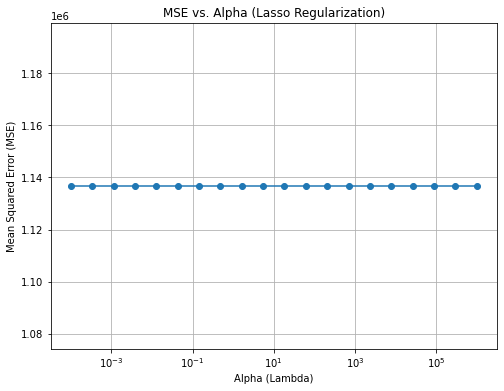

In [480]:
# Create a line plot of MSE values
plt.figure(figsize=(8, 6))
plt.plot(lambdas, perform, marker='o')
plt.xscale('log')  # Use a logarithmic scale for x-axis (optional)
plt.title('MSE vs. Alpha (Lasso Regularization)')
plt.xlabel('Alpha (Lambda)')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
# Save the figure as a JPEG image
plt.savefig('Lasso_regularization.png', format='png')
plt.show()

OPTIMAL LASSO

In [451]:
from sklearn.metrics import mean_squared_error as mse

scaler = StandardScaler()
poly_trans = PolynomialFeatures(degree=2)

# APPLY POLYNOMIAL TRANSFORMATION
X_train_poly = poly_trans.fit_transform(X_dev) 
X_test_poly = poly_trans.transform(X_test)

X_dev_st = scaler.fit_transform(X_train_poly)
X_test_st = scaler.transform(X_test_poly)

lasso_model = Lasso(alpha=optimal)  # Adjust the alpha parameter as needed
lasso_model.fit(X_dev_st, y_dev)

# Make predictions on the test set
y_pred = lasso_model.predict(X_test_st)

# Calculate the Mean Squared Error (MSE)
rmse = np.sqrt(mse(y_test, y_pred))
print("RMSE:",rmse)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

RMSE: 1146872.148675677
R-squared: 0.81436039191918


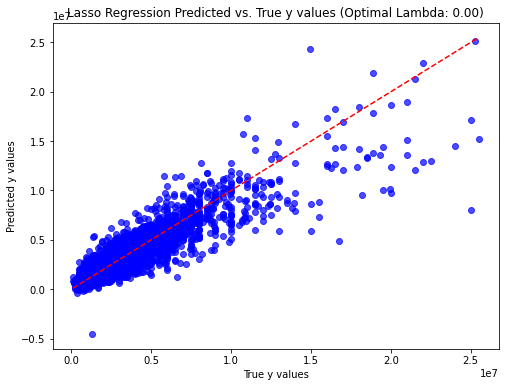

In [452]:
# Plot the predicted y values against true y values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.xlabel('True y values')
plt.ylabel('Predicted y values')
plt.title(f'Lasso Predicted vs. True y values (Optimal Lambda: {optimal:.2f})')
plt.grid(False)
plt.show()

## Ridge

In [453]:
def create_pipeline_ridge(degree,lambdas):
    return make_pipeline(PolynomialFeatures(degree=degree, include_bias=False), 
                               StandardScaler(),
                               RidgeCV(alphas=lambdas, cv=5))

lambdas = np.logspace(-4, 6, 20)
degree = 1

perform = []

for lambda_ in lambdas:
    
    pipe_ridge = create_pipeline_ridge(degree, lambdas)
    pipe_ridge.fit(X_dev, y_dev)
    
    y_pred = pipe_ridge.predict(X_test)
    rmse = np.sqrt(mse(y_pred, y_test))
    perform.append(rmse)

# Create a Series with performance and find parameter with lowest RMSE
hyperparam_perform = pd.Series(perform, index=lambdas)
optimal = hyperparam_perform.idxmin()

y_pred = pipe_ridge.predict(X_test)  # Predict using the best lambda
r2 = r2_score(y_test, y_pred)

print(f"Degree {degree} Polynomial - R squared: {r2:.4f}")
print(f"Degree {degree} Polynomial - Best Lambda: {optimal:.8f}")
print(f"Degree {degree} Polynomial - RMSE: {hyperparam_perform[optimal]:.2f}")

Degree 1 Polynomial - R squared: 0.7398
Degree 1 Polynomial - Best Lambda: 0.00010000
Degree 1 Polynomial - RMSE: 1357782.66


In [454]:
from sklearn.metrics import mean_squared_error as mse

degree = 2

perform = []

for lambda_ in lambdas:
    
    pipe_ridge = create_pipeline_ridge(degree, lambdas)
    pipe_ridge.fit(X_dev, y_dev)
    
    y_pred = pipe_ridge.predict(X_test)
    rmse = np.sqrt(mse(y_pred, y_test))
    perform.append(rmse)

# Create a Series with performance and find parameter with lowest RMSE
hyperparam_perform = pd.Series(perform, index=lambdas)
optimal = hyperparam_perform.idxmin()

y_pred = pipe_ridge.predict(X_test)  # Predict using the best lambda
r2 = r2_score(y_test, y_pred)

print(f"Degree {degree} Polynomial - R squared: {r2:.4f}")
print(f"Degree {degree} Polynomial - Best Lambda: {optimal:.8f}")
print(f"Degree {degree} Polynomial - RMSE: {hyperparam_perform[optimal]:.2f}")

Degree 2 Polynomial - R squared: 0.8176
Degree 2 Polynomial - Best Lambda: 0.00010000
Degree 2 Polynomial - RMSE: 1136767.00


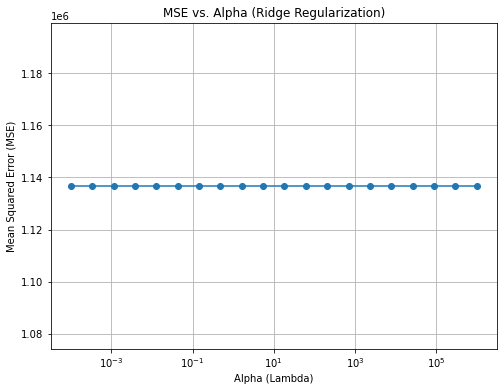

In [481]:
# Create a line plot of MSE values
plt.figure(figsize=(8, 6))
plt.plot(lambdas, perform, marker='o')
plt.xscale('log')  # Use a logarithmic scale for x-axis (optional)
plt.title('MSE vs. Alpha (Ridge Regularization)')
plt.xlabel('Alpha (Lambda)')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
# Save the figure as a JPEG image
plt.savefig('Ridge_regularization.png', format='png')
plt.show()

In [473]:
from sklearn.metrics import mean_squared_error as mse

scaler = StandardScaler()
poly_trans = PolynomialFeatures(degree=2)

# APPLY POLYNOMIAL TRANSFORMATION
X_train_poly = poly_trans.fit_transform(X_dev) 
X_test_poly = poly_trans.transform(X_test)

X_dev_st = scaler.fit_transform(X_train_poly)
X_test_st = scaler.transform(X_test_poly)

ridge_model = Ridge(alpha=0.0001)  # Adjust the alpha parameter as needed
ridge_model.fit(X_dev_st, y_dev)

# Make predictions on the test set
y_pred = ridge_model.predict(X_test_st)

# Calculate the Mean Squared Error (MSE)
rmse = np.sqrt(mse(y_test, y_pred))
print("RMSE:",rmse)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

RMSE: 1136702.3653084952
R-squared: 0.8176380792291916


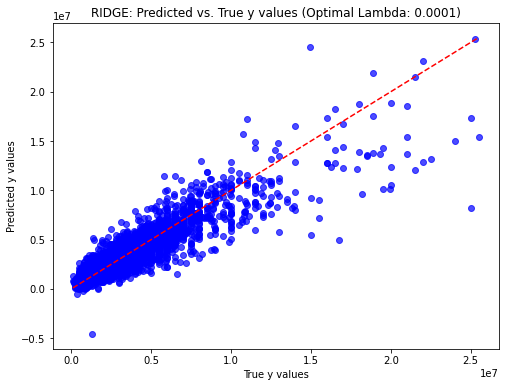

In [482]:
# Plot the predicted y values against true y values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.xlabel('True y values')
plt.ylabel('Predicted y values')
plt.title(f'RIDGE: Predicted vs. True y values (Optimal Lambda: {optimal:.4f})')
plt.grid(False)
# Save the figure as a JPEG image
plt.savefig('Ridge_prediction.png', format='png')
plt.show()

## Compare Models

### Learning curves

In [458]:
# LOAD FROM SCIKIT-LEARN
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=ridge_model,
                   X=X_dev,
                   y=y_dev,
                   train_sizes=np.arange(0.05, 1.05, .05),
                   scoring='neg_mean_squared_error',                 
                   cv=5)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))

mse_.head(10)

Train          Test
sample size                            
835          1.886689e+12  1.920129e+12
1671         1.727970e+12  1.880999e+12
2507         1.683202e+12  1.859887e+12
3343         1.733947e+12  1.853466e+12
4179         1.756029e+12  1.845914e+12
5015         1.797118e+12  1.841606e+12
5850         1.795877e+12  1.838774e+12
6686         1.808619e+12  1.836258e+12
7522         1.801267e+12  1.834097e+12
8358         1.807356e+12  1.832085e+12

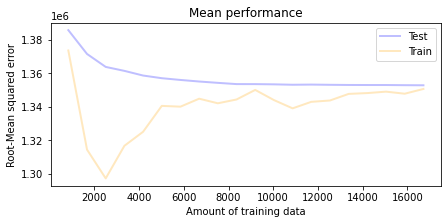

In [477]:
f_learn, ax = plt.subplots(figsize=(7,3))
ax.plot(train_sizes,np.sqrt(-test_scores.mean(1)), alpha=0.25, linewidth=2, label ='Test', color='blue') # negated, because we already use neg_MSE
ax.plot(train_sizes,np.sqrt(-train_scores.mean(1)), alpha=0.25, linewidth=2, label='Train', color='orange') # negated, because we already use neg_MSE

ax.set_title('Mean performance')
ax.set_ylabel('Root-Mean squared error')
ax.set_xlabel('Amount of training data')
ax.legend();

# Save the figure as a JPEG image
plt.savefig('Learning_curve.png', format='png')

# Normal OLS for comparison

In [460]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Add a constant term to X
X = sm.add_constant(X)

# Fit OLS regression model
model = sm.OLS(y, X).fit()

# Print regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     3761.
Date:                Mon, 21 Aug 2023   Prob (F-statistic):               0.00
Time:                        12:56:03   Log-Likelihood:            -4.0583e+05
No. Observations:               26122   AIC:                         8.117e+05
Df Residuals:                   26101   BIC:                         8.119e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                5.829e+06   3

C:\Users\marko\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
